In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import inv
import torch
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as I
from torch.nn import Sigmoid
from torch import transpose
from sklearn.neural_network import BernoulliRBM

import warnings
warnings.simplefilter('ignore')

In [15]:
def pourcentage(n_components,B,G):
    
    percents=[]
    numerators=[]
    
    denominator = np.zeros((B.shape[0],G.shape[1]))
    for i in range(n_components):
    
        denominator += np.matmul(B[:,i].reshape((B.shape[0],1)),G[i,:].reshape((1,G.shape[1])))
        numerator = np.matmul(B[:,i].reshape((B.shape[0],1)),G[i,:].reshape((1,G.shape[1])))
        numerators.append(numerator)

        
    for i in range(n_components):
        
        percents.append(numerators[i]/(denominator+0.001))
    
    return percents

In [26]:
samplerate, data = read("../data/mix_signal.wav")
music=data[:,0]
length=music.shape[0]/samplerate
print('Shape of the data {}'.format(music.shape[0]))
print('Length : {:.2f}s'.format(length))
print('Sample rate : {}'.format(samplerate))

Shape of the data 3276667
Length : 74.30s
Sample rate : 44100


# Apply STFT :

## We can change :

* Window : Type of window
* nperseg : length of window
* noverlap : overlap between windows.
* nfft : fft length > window size

In [28]:
WINDOW = 'hamming'
WINDOW_SIZE=480
OVERLAP = 0.6 * WINDOW_SIZE
NFFT=512

In [29]:
f,t,Y= signal.stft(music,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs=np.abs(Y)

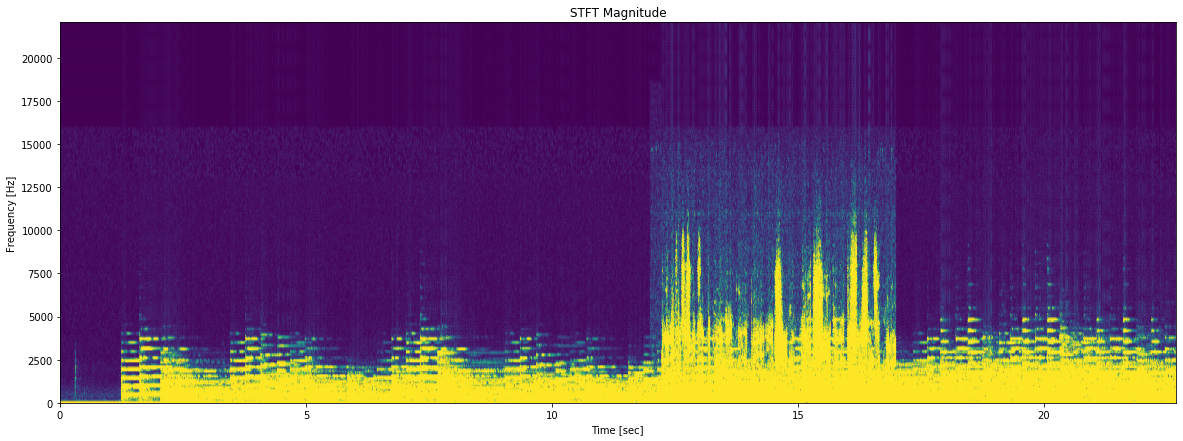

In [10]:
plt.figure(figsize=(20,7))
plt.pcolormesh(t, f, np.abs(Y),vmin=0, vmax=20, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [29]:
 _, xrec =  signal.istft(Y,
                          samplerate,
                          window = WINDOW,
                          nperseg=WINDOW_SIZE,
                          noverlap=OVERLAP,
                          nfft = NFFT)
write("Test_output/STFT.wav", samplerate, xrec.astype(np.int16))

# NMF:

In [34]:
n_components=2

Yabs[Yabs==0]=0.001

In [35]:
model = NMF(n_components=n_components, init='random',alpha=0.5,beta_loss='itakura-saito',solver="mu",max_iter=500, random_state=0)
B = model.fit_transform(Yabs)
G = model.components_

In [13]:
print('shape of bases : {}'.format(B.shape))
print('shape of wheights : {}'.format(G.shape))

shape of bases : (257, 2)
shape of wheights : (2, 4168)


# Estimation of the magnitude of the sources:

In [23]:
percents = pourcentage(n_components,B,G)
Sources=[]

for i in range(n_components):
    
    Sources.append(np.multiply(percents[i],Yabs))
    
print('Source shape = {}'.format(Sources[0].shape))

Source shape = (257, 10418)


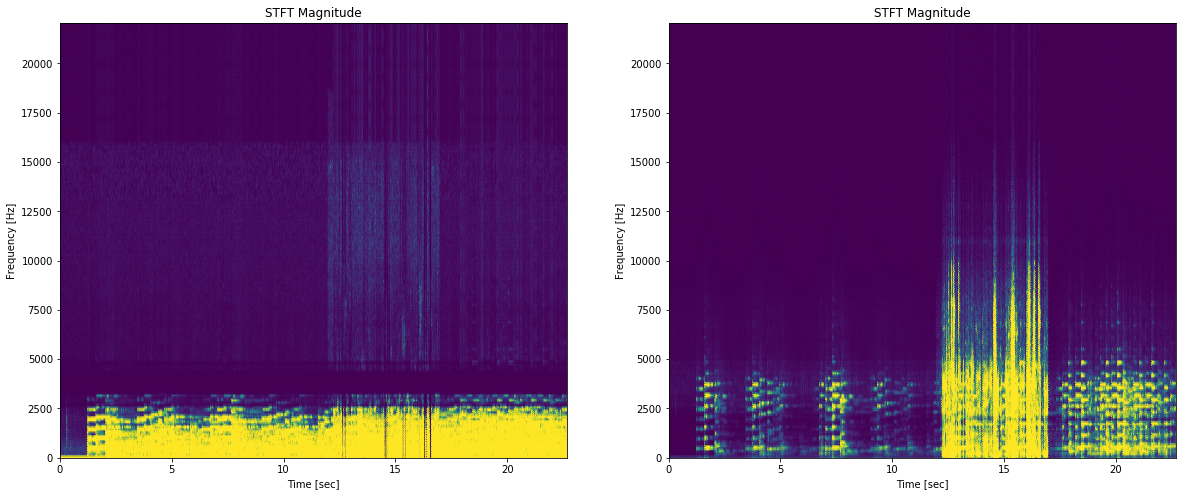

In [17]:
fig,ax=plt.subplots(1,n_components,figsize=(20,8))

for i in range(n_components):
        
        ax[i].pcolormesh(t, f,Sources[i],vmin=0, vmax=20, shading='gouraud')
        ax[i].set_title('STFT Magnitude')
        ax[i].set_ylabel('Frequency [Hz]')
        ax[i].set_xlabel('Time [sec]')

In [24]:
for i in range(n_components):
    
    _, xrec =  signal.istft(Sources[i],
                          samplerate,
                          window = "hamming",
                          nperseg=480,
                          noverlap=480*0.5,
                          nfft = 512)
    write("../data/example"+str(i)+".wav", samplerate, xrec.astype(np.int16))

# Test using different configs of NMF:

In [190]:
def itakura_saito(Y,B,G):
    
    reconstruction = np.matmul(B,G)
    div = Y / reconstruction
    cost = np.sum(div-np.log(div)) -np.product(Y.shape)
    return cost
            

In [201]:
costs=[]
inits=['random', 'nndsvda']
for init in inits:
    model = NMF(n_components=n_components, init=init,beta_loss='itakura-saito',solver="mu",max_iter=500, random_state=0)
    B = model.fit_transform(Zxxabs)
    G = model.components_
    costs.append(itakura_saito(Zxxabs,B,G))

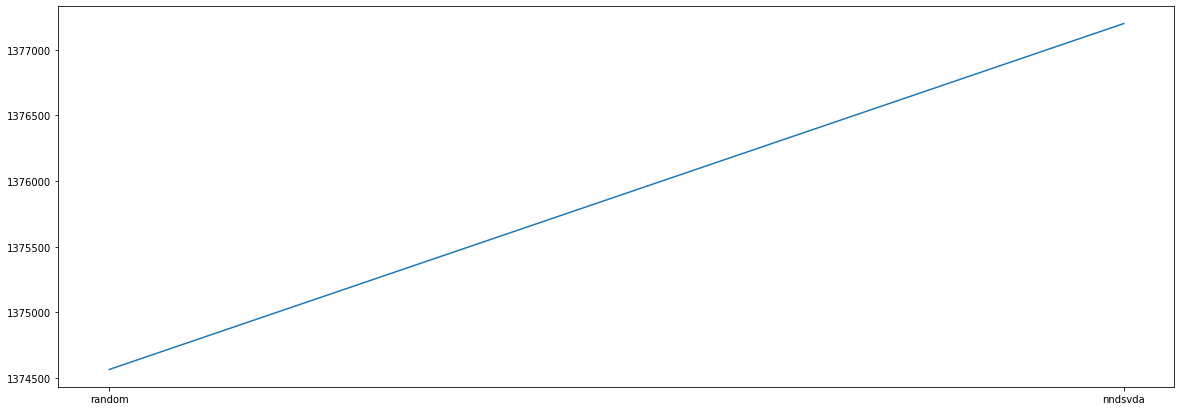

In [202]:
plt.figure(figsize=(20,7))
plt.plot(inits,costs)

# Dataloader:

In [98]:
s1=Sources[0]
s2=Sources[1]
print('Source shape : {}'.format(s1.shape))

Source shape : (257, 2085)


In [106]:
from torch.utils.data import Dataset, DataLoader


class AudioDataset(Dataset):
    """Sources dataset."""

    def __init__(self, Y, s1,s2):
        
        self.s1 = torch.tensor(s1)
        self.s2 = torch.tensor(s2)
        self.Y = Y
        
    def __len__(self):
        return self.s1.size()[1]

    def __getitem__(self, idx):
        
        return {'Y':self.Y[:,idx],'s1': self.s1[:,idx], 's2': self.s2[:,idx]}
    

In [107]:
# load training data in batches
dataset=AudioDataset(Y, s1, s2)
print('Number of samples in the audio is {}'.format(len(dataset)))
batch_size = 256
train_loader = DataLoader(dataset, 
                          batch_size=batch_size,
                          shuffle=False, 
                          num_workers=0)

Number of samples in the audio is 2085


In [108]:
s11=[]
for i, data in enumerate(train_loader):
    
    print('Shape of data s1 {}'.format(data['s1'].shape))
    print('Shape of data s2 {}'.format(data['s2'].shape))

Shape of data s1 torch.Size([256, 257])
Shape of data s2 torch.Size([256, 257])
Shape of data s1 torch.Size([256, 257])
Shape of data s2 torch.Size([256, 257])
Shape of data s1 torch.Size([256, 257])
Shape of data s2 torch.Size([256, 257])
Shape of data s1 torch.Size([256, 257])
Shape of data s2 torch.Size([256, 257])
Shape of data s1 torch.Size([256, 257])
Shape of data s2 torch.Size([256, 257])
Shape of data s1 torch.Size([256, 257])
Shape of data s2 torch.Size([256, 257])
Shape of data s1 torch.Size([256, 257])
Shape of data s2 torch.Size([256, 257])
Shape of data s1 torch.Size([256, 257])
Shape of data s2 torch.Size([256, 257])
Shape of data s1 torch.Size([37, 257])
Shape of data s2 torch.Size([37, 257])
